In [1]:
using QuantEcon
using BasisMatrices
using ContinuousDPs
using PyPlot

In [2]:
alpha = 0.4
beta = 0.96
mu = 0
sigma = 0.1;

In [3]:
f(s, x) = log(x)
g(s, x, e) = (s - x)^alpha * e;

In [4]:
shock_size = 250
shocks = exp.(mu + sigma * randn(shock_size))
weights = fill(1/shock_size, shock_size);

In [5]:
grid_max = 4.
n = 30
s_min, s_max = 1e-5, grid_max
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (1.0e-5,) × (4.0,).
Basis families are Cheb


In [6]:
x_lb(s) = s_min
x_ub(s) = s;

In [7]:
ab = alpha * beta
c1 = log(1 - ab) / (1 - beta)
c2 = (mu + alpha * log(ab)) / (1 - alpha)
c3 = 1 / (1 - beta)
c4 = 1 / (1 - ab)

# True optimal policy
c_star(y) = (1 - alpha * beta) * y

# True value function
v_star(y) = c1 + c2 * (c3 - c4) + c4 * log(y);

In [8]:
cdp = ContinuousDP(f, g, beta, shocks, weights, x_lb, x_ub, basis);

## First Test

In [9]:
C_star = cdp.interp.Phi \ v_star.(cdp.interp.S)
Tv = Array{Float64}(cdp.interp.length)
C = copy(C_star)
bellman_operator!(cdp, C, Tv);

In [10]:
grid_size = 200
grid_y = collect(linspace(s_min, s_max, grid_size))
V_approx = funeval(C, cdp.interp.basis, grid_y);

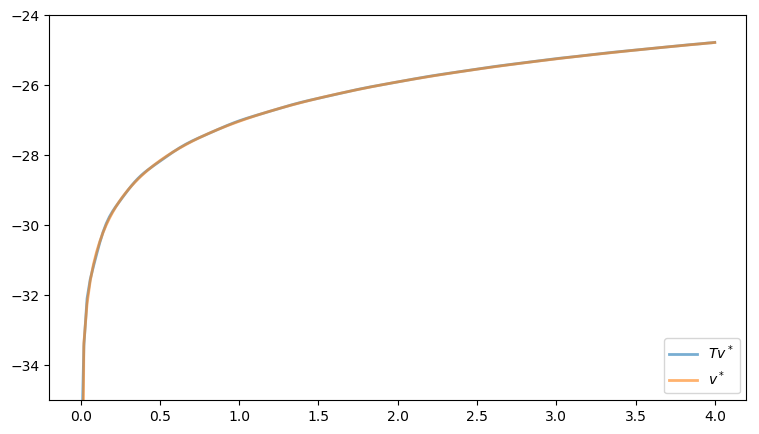

In [11]:
fig, ax = subplots(figsize=(9, 5))
ax[:set_ylim](-35, -24)
ax[:plot](grid_y, V_approx, lw=2, alpha=0.6, label=L"$Tv^*$")
ax[:plot](grid_y, v_star.(grid_y), lw=2, alpha=0.6, label=L"$v^*$")
ax[:legend](loc="lower right")
show()

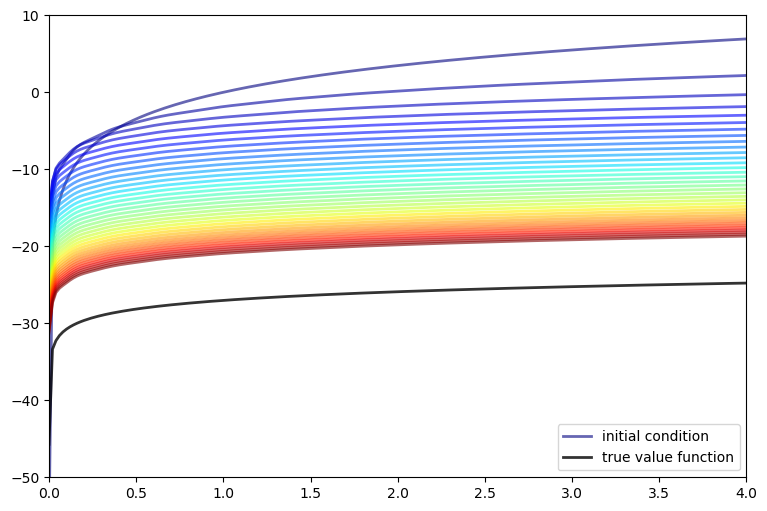

In [12]:
v_init_func(s) = 5 * log(s)
w = v_init_func.(grid_y)
n = 35

fig, ax = subplots(figsize=(9, 6))
ax[:set_ylim](-50, 10)
ax[:set_xlim](minimum(grid_y), maximum(grid_y))
lb = "initial condition"
jet = ColorMap("jet")
ax[:plot](grid_y, w, color=jet(0), lw=2, alpha=0.6, label=lb)

S = cdp.interp.S
V = v_init_func.(S)
for i in 1:n
    C = cdp.interp.Phi \ V
    bellman_operator!(cdp, C, V)
    w = funeval(C, cdp.interp.basis, grid_y)
    ax[:plot](grid_y, w, color=jet(i / n), lw=2, alpha=0.6)
end

lb = "true value function"
ax[:plot](grid_y, v_star.(grid_y), "k-", lw=2, alpha=0.8, label=lb)
ax[:legend](loc="lower right")

show()

## Solve by Policy Iteration

In [13]:
res = solve(cdp);

Compute iterate 6 with error 5.684341886080802e-14
Converged in 6 steps


In [14]:
set_eval_nodes!(res, grid_y);

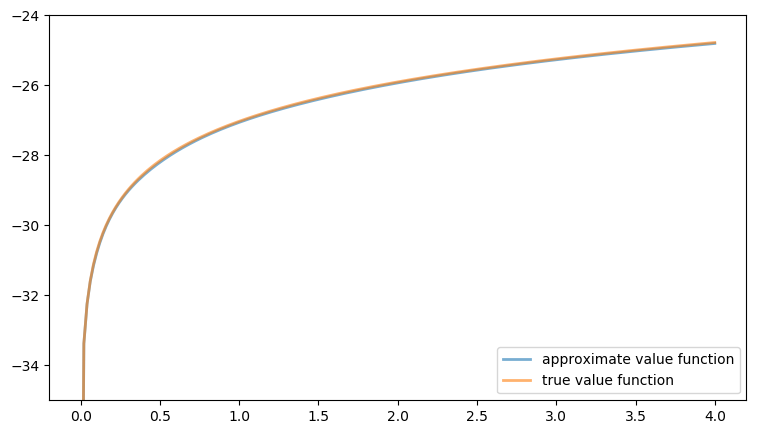

In [15]:
fig, ax = subplots(figsize=(9, 5))
ax[:set_ylim](-35, -24)
ax[:plot](grid_y, res.V, lw=2, alpha=0.6, label="approximate value function")
ax[:plot](grid_y, v_star.(grid_y), lw=2, alpha=0.6, label="true value function")
ax[:legend](loc="lower right")
show()

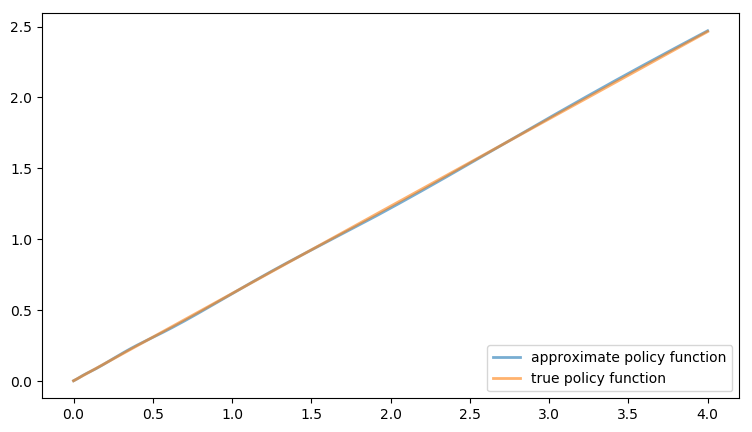

In [16]:
fig, ax = subplots(figsize=(9, 5))
ax[:plot](grid_y, res.X, lw=2, alpha=0.6, label="approximate policy function")
ax[:plot](grid_y, c_star.(grid_y), lw=2, alpha=0.6, label="true policy function")
ax[:legend](loc="lower right")
show()

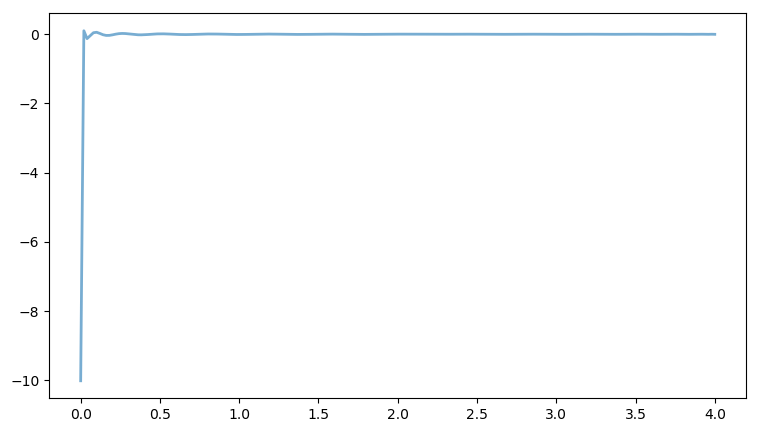

In [17]:
fig, ax = subplots(figsize=(9, 5))
ax[:plot](grid_y, res.resid, lw=2, alpha=0.6, label="residual")
show()